## 1. Загрузка изображения и преобразование цветного к полутоновому

In [995]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [997]:
def get_image(path):
    return cv2.imread(path)

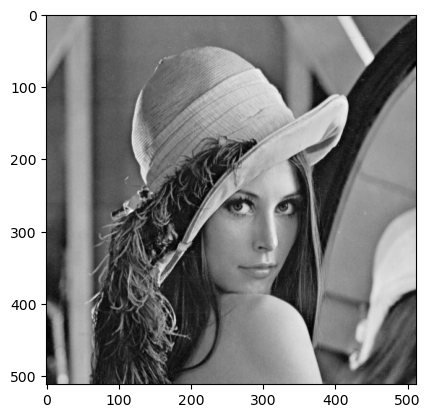

In [999]:
image = get_image('lenna.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')

## 2. Квантование по яркости (с ручным заданием количества уровней)

In [1081]:
# Квантование относительно массива трешхолдов
def quantize_based_on_array(image, values):
    quantized_image = np.zeros_like(image)
    for i in range(len(values) - 1):
        lower_bound = values[i]
        upper_bound = values[i + 1]
        mask = (image >= lower_bound) & (image < upper_bound)
        quantized_image[mask] = lower_bound  # Присваиваем нижний предел всем пикселям, попадающим в диапазон
    quantized_image[image >= values[-1]] = values[-1]  # Присваиваем верхний предел для всех пикселей выше последнего значения
    return quantized_image

In [1083]:
def quantize(image, levels):
    normalized_image = image / 255
    quantized_image = np.floor(normalized_image * levels) / levels
    return (quantized_image * 255).astype(np.uint8)

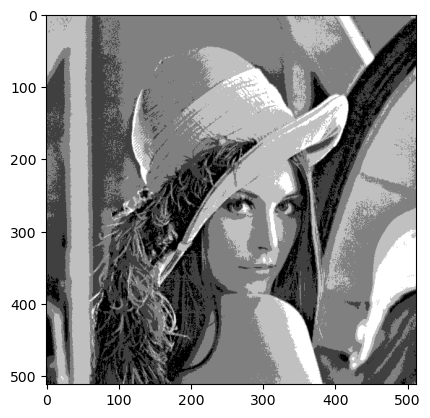

In [1085]:
quantized_image = quantize(image, 5)
plt.imshow(quantized_image, cmap='gray')

## 3. Бинаризация

### 3.1 Бинаризация методом Оцу глобальная

In [1089]:
def global_otsu(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

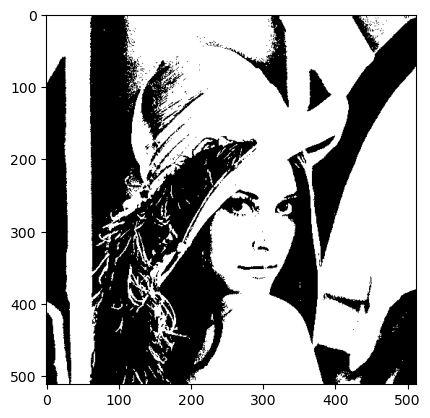

In [1091]:
_, binary_image = global_otsu(image)
plt.imshow(binary_image, cmap='gray')

### 3.2 Бинаризация методом Оцу локальная (с предварительным разбиением на фрагменты - по каждому своя бинаризация)

In [1094]:
def local_otsu(image, fragments):
    h, w = image.shape
    thresholds = []
    
    fragment_width = w // fragments
    
    for i in range(fragments):
        # Определяем границы текущего фрагмента
        start_x = i * fragment_width
        end_x = (i + 1) * fragment_width if (i + 1) < fragments else w
    
        fragment = image[:, start_x:end_x]
        
        threshold, _ = global_otsu(fragment)
        thresholds.append(threshold)

    return thresholds

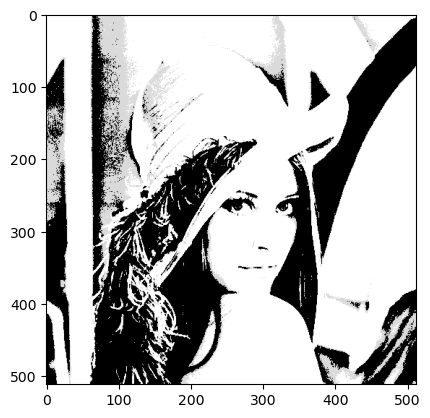

In [1096]:
thresholds = local_otsu(image, 4)
local_otsu_image = quantize_based_on_array(image, thresholds)
plt.imshow(local_otsu_image, cmap='gray')

In [1098]:
thresholds

[123.0, 98.0, 121.0, 115.0]

### 3.3 Бинаризация методом Оцу иерархическая (выполняется с иерархическим разбиением каждой уже полученной  области, пока возможно разбивать). Квантование с использованием найденных порогов

In [1101]:
def otsu_binarization_hierarchical(image, min_size):
    thresholds = []  # Список для хранения порогов
    def recursive_otsu(image):
        h, w = image.shape
        if h <= min_size or w <= min_size:
            threshold, _ = global_otsu(image)
            thresholds.append(threshold)
            return

        threshold, _ = global_otsu(image)
        thresholds.append(threshold)

        # Разбиение области на 4 части
        h_half, w_half = h // 2, w // 2
        recursive_otsu(image[:h_half, :w_half])  # Левое верхнее
        recursive_otsu(image[:h_half, w_half:])   # Правое верхнее
        recursive_otsu(image[h_half:, :w_half])    # Левое нижнее
        recursive_otsu(image[h_half:, w_half:])     # Правое нижнее
        
    recursive_otsu(image)

    return thresholds

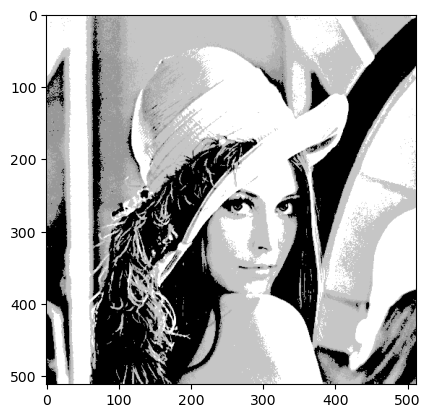

In [1103]:
thresholds = otsu_binarization_hierarchical(image, 128)
quantized_image = quantize_based_on_array(image, thresholds)
plt.imshow(quantized_image, cmap='gray')